1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


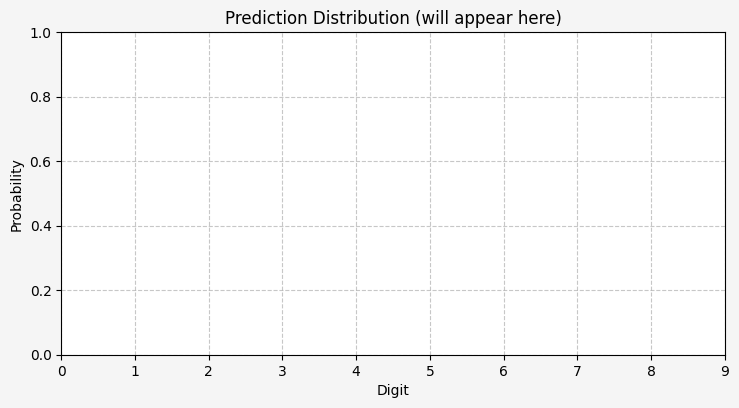

In [2]:
import tkinter as tk
from tkinter import ttk, filedialog, messagebox
from PIL import Image, ImageTk, ImageOps
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import seaborn as sns
import time
from PIL import ImageGrab


class DigitClassifierApp:
    def __init__(self, root):
        self.root = root
        self.root.title("MNIST Digit Classifier")
        self.root.geometry("1100x750")
        self.root.resizable(True, True)
        self.root.minsize(900, 650)
        
        # Initialize variables
        self.model_loaded = False
        self.image_loaded = False
        self.processing = False
        
        # Configure style
        self.setup_style()
        
        # Create loading screen
        self.show_loading_screen()
        
        # Load model in background
        self.root.after(100, self.load_model_async)
        
    def setup_style(self):
        self.style = ttk.Style()
        self.style.theme_use('clam')
        
        # Colors
        self.bg_color = "#f5f5f5"
        self.primary_color = "#4a6fa5"
        self.secondary_color = "#166088"
        self.accent_color = "#4fc3f7"
        self.error_color = "#f44336"
        self.success_color = "#4CAF50"
        self.warning_color = "#FFC107"
        self.text_color = "#333333"
        
        # Configure styles
        self.style.configure('TFrame', background=self.bg_color)
        self.style.configure('TLabel', background=self.bg_color, foreground=self.text_color)
        self.style.configure('TButton', 
                           background=self.primary_color, 
                           foreground="white",
                           font=('Helvetica', 10),
                           padding=6)
        self.style.map('TButton',
                      background=[('active', self.secondary_color), ('disabled', '#cccccc')])
        self.style.configure('Header.TLabel', 
                           font=('Helvetica', 16, 'bold'),
                           foreground=self.primary_color)
        self.style.configure('Accent.TButton', 
                           background=self.accent_color,
                           foreground="white",
                           font=('Helvetica', 10, 'bold'))
        self.style.configure('Success.TLabel',
                           foreground=self.success_color)
        self.style.configure('Error.TLabel',
                           foreground=self.error_color)
        self.style.configure('Warning.TLabel',
                           foreground=self.warning_color)
        
    def show_loading_screen(self):
        """Show loading screen while model is loading"""
        self.loading_frame = ttk.Frame(self.root)
        self.loading_frame.pack(fill=tk.BOTH, expand=True)
        
        ttk.Label(self.loading_frame, 
                 text="Loading HANDWRITTEN DIGIT RECOGNIZER", 
                 style='Header.TLabel').pack(pady=20)
        
        self.loading_label = ttk.Label(self.loading_frame, 
                                     text="Initializing model...",
                                     font=('Helvetica', 12))
        self.loading_label.pack(pady=10)
        
        self.progress = ttk.Progressbar(self.loading_frame, 
                                       mode='indeterminate',
                                       length=300)
        self.progress.pack(pady=10)
        self.progress.start()
        
    def load_model_async(self):
        """Load model in background to prevent UI freezing"""
        try:
            self.model = load_model('mnist_digit_classifier_final.keras')
            self.model_loaded = True
            self.loading_label.config(text="Model loaded successfully!")
            self.progress.stop()
            self.root.after(1000, self.create_main_ui)
        except Exception as e:
            self.loading_label.config(text=f"Failed to load model: {str(e)}", style='Error.TLabel')
            self.progress.stop()
            ttk.Button(self.loading_frame, 
                       text="Exit", 
                       command=self.root.destroy).pack(pady=20)
            messagebox.showerror("Error", f"Failed to load model: {str(e)}")
    
    def create_main_ui(self):
        """Create main UI after model is loaded"""
        self.loading_frame.destroy()
        
        # Main container
        self.main_frame = ttk.Frame(self.root, padding="10")
        self.main_frame.pack(fill=tk.BOTH, expand=True)
        
        # Header
        self.header_frame = ttk.Frame(self.main_frame)
        self.header_frame.pack(fill=tk.X, pady=(0, 20))
        
        ttk.Label(self.header_frame, 
                 text="HANDWRITTEN DIGIT RECOGNIZER", 
                 style='Header.TLabel').pack(side=tk.LEFT)
        
        # Model status indicator
        self.model_status = ttk.Label(self.header_frame, 
                                    text="Model: Ready",
                                    style='Success.TLabel')
        self.model_status.pack(side=tk.RIGHT)
        
        # Content area
        self.content_frame = ttk.Frame(self.main_frame)
        self.content_frame.pack(fill=tk.BOTH, expand=True)
        
        # Left panel (controls)
        self.left_panel = ttk.Frame(self.content_frame, width=300)
        self.left_panel.pack(side=tk.LEFT, fill=tk.Y, padx=(0, 20))
        
        # Right panel (display)
        self.right_panel = ttk.Frame(self.content_frame)
        self.right_panel.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)
        
        # Control buttons
        self.control_frame = ttk.LabelFrame(self.left_panel, text="Controls", padding=15)
        self.control_frame.pack(fill=tk.X, pady=(0, 20))
        
        self.load_btn = ttk.Button(self.control_frame, 
                                 text="Load Image", 
                                 command=self.load_image,
                                 style='Accent.TButton')
        self.load_btn.pack(fill=tk.X, pady=5)
        
        self.clear_btn = ttk.Button(self.control_frame, 
                                  text="Clear", 
                                  command=self.clear_display,
                                  state=tk.DISABLED)
        self.clear_btn.pack(fill=tk.X, pady=5)
        
        # Drawing canvas option
        self.draw_frame = ttk.LabelFrame(self.control_frame, text="Draw Digit", padding=10)
        self.draw_frame.pack(fill=tk.X, pady=(10, 0))
        
        ttk.Button(self.draw_frame, 
                  text="Open Drawing Canvas", 
                  command=self.open_drawing_canvas).pack(fill=tk.X)
        
        # Prediction info
        self.info_frame = ttk.LabelFrame(self.left_panel, text="Prediction", padding=15)
        self.info_frame.pack(fill=tk.X)
        
        self.prediction_label = ttk.Label(self.info_frame, 
                                        text="No image loaded",
                                        font=('Helvetica', 14),
                                        anchor=tk.CENTER)
        self.prediction_label.pack(fill=tk.X, pady=5)
        
        self.confidence_label = ttk.Label(self.info_frame, 
                                        text="",
                                        font=('Helvetica', 12),
                                        anchor=tk.CENTER)
        self.confidence_label.pack(fill=tk.X, pady=5)
        
        # Additional info
        self.info_text = tk.Text(self.info_frame, 
                               height=6, 
                               wrap=tk.WORD,
                               font=('Helvetica', 10),
                               padx=5, pady=5)
        self.info_text.pack(fill=tk.X)
        self.info_text.insert(tk.END, "Instructions:\n1. Load an image of a digit\n2. Or draw a digit in the canvas")
        self.info_text.config(state=tk.DISABLED)
        
        # Image display
        self.image_frame = ttk.LabelFrame(self.right_panel, text="Image", padding=15)
        self.image_frame.pack(fill=tk.BOTH, expand=True)
        
        self.image_label = ttk.Label(self.image_frame, 
                                   text="No image loaded\n\nSupported formats: PNG, JPG, BMP",
                                   anchor=tk.CENTER,
                                   font=('Helvetica', 12))
        self.image_label.pack(fill=tk.BOTH, expand=True)
        
        # Probability chart
        self.chart_frame = ttk.LabelFrame(self.right_panel, text="Prediction Probabilities", padding=15)
        self.chart_frame.pack(fill=tk.BOTH, expand=True)
        
        self.figure = plt.figure(figsize=(6, 3), dpi=100, facecolor=self.bg_color)
        self.canvas = FigureCanvasTkAgg(self.figure, master=self.chart_frame)
        self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        # Initial empty chart
        self.create_empty_chart()
        
        # Status bar
        self.status_bar = ttk.Label(self.main_frame, 
                                  text="Ready",
                                  relief=tk.SUNKEN,
                                  anchor=tk.W)
        self.status_bar.pack(fill=tk.X, side=tk.BOTTOM, ipady=2)
        
    def create_empty_chart(self):
        """Create an empty placeholder chart"""
        self.figure.clear()
        ax = self.figure.add_subplot(111)
        ax.set_xticks(range(10))
        ax.set_ylim(0, 1)
        ax.set_xlabel('Digit')
        ax.set_ylabel('Probability')
        ax.set_title('Prediction Distribution (will appear here)')
        ax.grid(True, linestyle='--', alpha=0.7)
        self.canvas.draw()
    
    def load_image(self):
        """Load and process an image file"""
        if not self.model_loaded:
            messagebox.showerror("Error", "Model not loaded properly")
            return
            
        file_types = [
            ("PNG files", "*.png"),
            ("JPEG files", "*.jpg *.jpeg"),
            ("Bitmap files", "*.bmp"),
            ("All files", "*.*")
        ]
        
        file_path = filedialog.askopenfilename(
            title="Select an image file",
            filetypes=file_types
        )
        
        if not file_path:
            return
        
        try:
            # Show processing state
            self.set_processing_state(True)
            self.status_bar.config(text=f"Processing: {file_path}")
            
            # Load and display image
            self.display_image = Image.open(file_path)
            self.display_image = self.display_image.resize((280, 280), Image.LANCZOS)
            self.tk_image = ImageTk.PhotoImage(self.display_image)
            self.image_label.config(image=self.tk_image, text="")
            self.image_loaded = True
            self.clear_btn.config(state=tk.NORMAL)
            
            # Validate image dimensions
            if self.display_image.size[0] < 20 or self.display_image.size[1] < 20:
                messagebox.showwarning("Warning", "Image is very small. For best results, use larger images.")
            
            # Preprocess and predict
            processed_img = self.preprocess_image(file_path)
            if processed_img is not None:
                # Show progress
                self.prediction_label.config(text="Processing...", style='Warning.TLabel')
                self.confidence_label.config(text="")
                self.root.update()
                
                # Simulate processing delay for better UX
                self.root.after(500, lambda: self.process_prediction(processed_img, file_path))
                
        except Exception as e:
            self.set_processing_state(False)
            messagebox.showerror("Error", f"Failed to process image: {str(e)}")
            self.status_bar.config(text=f"Error loading image: {file_path}")
            self.image_label.config(text="Error loading image\nPlease try another file")
    
    def process_prediction(self, processed_img, file_path):
        """Process the prediction and update UI"""
        try:
            prediction = self.model.predict(processed_img)
            digit = np.argmax(prediction)
            confidence = np.max(prediction) * 100
            
            # Update prediction labels
            self.prediction_label.config(
                text=f"Predicted Digit: {digit}",
                style='Success.TLabel'
            )
            confidence_text = f"Confidence: {confidence:.2f}%"
            self.confidence_label.config(
                text=confidence_text,
                style='Success.TLabel' if confidence > 70 else 'Warning.TLabel' if confidence > 50 else 'Error.TLabel'
            )
            
            # Add explanation to info text
            self.info_text.config(state=tk.NORMAL)
            self.info_text.delete(1.0, tk.END)
            
            if confidence > 90:
                confidence_msg = "The model is very confident about this prediction."
            elif confidence > 70:
                confidence_msg = "The model is fairly confident about this prediction."
            elif confidence > 50:
                confidence_msg = "The model is somewhat uncertain about this prediction."
            else:
                confidence_msg = "The model is very uncertain about this prediction. Try a clearer image."
            
            self.info_text.insert(tk.END, f"Analysis:\n{confidence_msg}\n\n")
            self.info_text.insert(tk.END, f"Top 3 predictions:\n")
            
            # Get top 3 predictions
            top3 = np.argsort(prediction[0])[-3:][::-1]
            for i, idx in enumerate(top3):
                self.info_text.insert(tk.END, f"{i+1}. Digit {idx}: {prediction[0][idx]*100:.2f}%\n")
            
            self.info_text.config(state=tk.DISABLED)
            
            # Update probability chart
            self.update_probability_chart(prediction[0])
            
            self.status_bar.config(text=f"Processed: {file_path}")
            
        except Exception as e:
            messagebox.showerror("Error", f"Prediction failed: {str(e)}")
            self.prediction_label.config(text="Prediction failed", style='Error.TLabel')
            self.confidence_label.config(text="")
            
        finally:
            self.set_processing_state(False)
    
    def preprocess_image(self, image_path):
        """Preprocess the image for model prediction"""
        try:
            img = Image.open(image_path).convert('L')  # Convert to grayscale
            
            # Check if image is mostly white (inverted)
            img_array = np.array(img)
            white_pixels = np.sum(img_array > 200)
            total_pixels = img_array.size
            if white_pixels / total_pixels > 0.7:  # > 70% white
                img = ImageOps.invert(img)
            
            img = img.resize((28, 28))  # Resize to 28x28 pixels
            img_array = np.array(img) / 255.0  # Normalize to [0,1]
            
            # Check if image is mostly empty
            if np.max(img_array) < 0.1:  # Very dark image
                messagebox.showwarning("Warning", "The image appears to be very faint or empty")
            
            img_array = img_array.reshape(1, 784)  # Flatten to 1x784
            return img_array
            
        except Exception as e:
            messagebox.showerror("Error", f"Image preprocessing failed: {str(e)}")
            return None
    
    def update_probability_chart(self, probabilities):
        """Update the probability chart with new data"""
        self.figure.clear()
        ax = self.figure.add_subplot(111)
        
        digits = range(10)
        bars = ax.bar(digits, probabilities, color=self.accent_color)
        
        # Highlight the predicted digit
        predicted_digit = np.argmax(probabilities)
        bars[predicted_digit].set_color(self.success_color)
        
        # Add value labels
        for i, rect in enumerate(bars):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height,
                   f'{height:.2f}',
                   ha='center', va='bottom', fontsize=8)
        
        ax.set_xticks(digits)
        ax.set_ylim(0, 1)
        ax.set_xlabel('Digit')
        ax.set_ylabel('Probability')
        ax.set_title('Prediction Distribution')
        ax.grid(True, linestyle='--', alpha=0.7)
        
        self.canvas.draw()
    
    def clear_display(self):
        """Clear the current display and reset"""
        self.image_label.config(image='', text="No image loaded\n\nSupported formats: PNG, JPG, BMP")
        self.prediction_label.config(text="No image loaded", style='TLabel')
        self.confidence_label.config(text="", style='TLabel')
        self.create_empty_chart()
        self.status_bar.config(text="Ready")
        
        # Clear any existing image references
        if hasattr(self, 'display_image'):
            del self.display_image
        if hasattr(self, 'tk_image'):
            del self.tk_image
            
        self.image_loaded = False
        self.clear_btn.config(state=tk.DISABLED)
        
        # Reset info text
        self.info_text.config(state=tk.NORMAL)
        self.info_text.delete(1.0, tk.END)
        self.info_text.insert(tk.END, "Instructions:\n1. Load an image of a digit\n2. Or draw a digit in the canvas")
        self.info_text.config(state=tk.DISABLED)
    
    def set_processing_state(self, processing):
        """Set the UI state during processing"""
        self.processing = processing
        if processing:
            self.load_btn.config(state=tk.DISABLED)
            self.clear_btn.config(state=tk.DISABLED)
            self.status_bar.config(text="Processing...")
        else:
            self.load_btn.config(state=tk.NORMAL)
            if self.image_loaded:
                self.clear_btn.config(state=tk.NORMAL)
            self.status_bar.config(text="Ready")
    
    def open_drawing_canvas(self):
        """Open a drawing canvas for user to draw digits"""
        canvas_window = tk.Toplevel(self.root)
        canvas_window.title("Draw a Digit")
        canvas_window.geometry("400x400")
        
        # Drawing canvas
        self.drawing_canvas = tk.Canvas(canvas_window, bg="white", width=280, height=280)
        self.drawing_canvas.pack(pady=10)
        
        # Controls
        control_frame = ttk.Frame(canvas_window)
        control_frame.pack(pady=10)
        
        ttk.Button(control_frame, text="Clear", command=self.clear_canvas).pack(side=tk.LEFT, padx=5)
        ttk.Button(control_frame, text="Predict", command=lambda: self.predict_drawing(self.drawing_canvas)).pack(side=tk.LEFT, padx=5)
        ttk.Button(control_frame, text="Close", command=canvas_window.destroy).pack(side=tk.LEFT, padx=5)
        
        # Drawing bindings
        self.drawing_canvas.bind("<B1-Motion>", self.draw_on_canvas)
        
        # Instructions
        ttk.Label(canvas_window, 
                 text="Draw a digit (0-9) in the white area above", 
                 font=('Helvetica', 10)).pack(pady=5)
    
    def draw_on_canvas(self, event):
        """Handle drawing on the canvas"""
        x, y = event.x, event.y
        r = 8  # Brush radius
        self.drawing_canvas.create_oval(x-r, y-r, x+r, y+r, fill="black", outline="black")
    
    def clear_canvas(self):
        """Clear the drawing canvas"""
        self.drawing_canvas.delete("all")
    
    def predict_drawing(self, canvas):
        """Predict the digit drawn on the canvas"""
        if not self.model_loaded:
            messagebox.showerror("Error", "Model not loaded properly")
            return
            
        try:
            # Save canvas as image
            canvas.postscript(file="tmp_drawing.eps", colormode="color")
            try:
                # First try with Ghostscript
                img = Image.open("tmp_drawing.eps")
                img.save("tmp_drawing.png", "png")
            except Exception as e:
                # Fallback method - capture canvas directly without PostScript
                self.status_bar.config(text="Using fallback method (no Ghostscript)")
                x = self.root.winfo_rootx() + canvas.winfo_x()
                y = self.root.winfo_rooty() + canvas.winfo_y()
                x1 = x + canvas.winfo_width()
                y1 = y + canvas.winfo_height()
                img = ImageGrab.grab().crop((x, y, x1, y1))
                img.save("tmp_drawing.png", "png")
            # Process and predict
            processed_img = self.preprocess_image("tmp_drawing.png")
            if processed_img is not None:
                # Show processing
                self.prediction_label.config(text="Processing drawing...", style='Warning.TLabel')
                self.confidence_label.config(text="")
                self.root.update()
                
                # Process prediction
                prediction = self.model.predict(processed_img)
                digit = np.argmax(prediction)
                confidence = np.max(prediction) * 100
                
                # Update UI
                self.prediction_label.config(
                    text=f"Predicted Digit: {digit}",
                    style='Success.TLabel'
                )
                self.confidence_label.config(
                    text=f"Confidence: {confidence:.2f}%",
                    style='Success.TLabel' if confidence > 70 else 'Warning.TLabel' if confidence > 50 else 'Error.TLabel'
                )
                
                # Update probability chart
                self.update_probability_chart(prediction[0])
                
                # Display the drawing in main window
                self.display_image = Image.open("tmp_drawing.png")
                self.display_image = self.display_image.resize((280, 280), Image.LANCZOS)
                self.tk_image = ImageTk.PhotoImage(self.display_image)
                self.image_label.config(image=self.tk_image, text="")
                self.image_loaded = True
                self.clear_btn.config(state=tk.NORMAL)
                
                self.status_bar.config(text="Processed drawing")
                
        except Exception as e:
            messagebox.showerror("Error", f"Failed to process drawing: {str(e)}")
            self.status_bar.config(text="Error processing drawing")

if __name__ == "__main__":
    root = tk.Tk()
    app = DigitClassifierApp(root)
    root.mainloop()